In [ ]:
import os, io, random
from src.data.load_data import *
from src.data.data_utils import *


os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)
torch.backends.cudnn.benchmark = True 

# Coniguración
BATCH_SIZE   = 32
PIN_MEMORY   = True
DROP_LAST    = True
SEED         = 7

# Tamaño de entrenamiento
SIZE         = 256
FINAL_SIZE   = 252  # usamos RandomResizedCrop directo a 252

# Targets de reducción (ajusta a gusto)
CONTENT_KEEP = 10000   # COCO
STYLE_KEEP   = 30000   # WikiArt

# Normalización ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Auto-select de workers (Kaggle suele tener 2 vCPU)
CPU_COUNT = os.cpu_count() or 2
NUM_WORKERS = 2 if CPU_COUNT <= 2 else min(4, CPU_COUNT - 1)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



# ======================================================
# Carga de COCO (content)
# ======================================================
coco_hf = load_dataset("phiyodr/coco2017", split="train")
coco_img_col = detect_image_col(coco_hf)
coco_hf = filter_valid_images(coco_hf, coco_img_col)
coco_hf = cast_to_image(coco_hf, coco_img_col)
coco_ds = HFDataset(coco_hf, img_key="image", transform=content_tf)
content_loader = make_loader(coco_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Recortamos COCO a CONTENT_KEEP
content_loader = truncate_dataloaders(content_loader, None, n=CONTENT_KEEP, seed=77)

# ======================================================
# Carga de WikiArt (style) con filtro por estilos útiles
# ======================================================
wiki_hf = load_dataset("davanstrien/wikiart-resized", split="train")
wiki_img_col = detect_image_col(wiki_hf)
wiki_hf = filter_valid_images(wiki_hf, wiki_img_col)

print("Total WikiArt original:", len(wiki_hf))
print("Columnas WikiArt:", wiki_hf.column_names)


style_feat = wiki_hf.features["style"] 
style_names = style_feat.names      

print("Estilos disponibles:", style_names)


GOOD_PATTERNS = [
    "impression",      
    "expression",      
    "fauvism",
    "baroque",
    "romantic",        
    "symbol",         
    "realism",
    "northern_renaissance",
    "naive_art",        
    "art_nouveau",]

# IDs de estilos buenos según el nombre
good_style_ids = []
for idx, name in enumerate(style_names):
    name_low = name.lower()
    if any(pat in name_low for pat in GOOD_PATTERNS):
        good_style_ids.append(idx)

print("IDs de estilos seleccionados:", good_style_ids)
print("Nombres de estilos seleccionados:",
      [style_names[i] for i in good_style_ids])

def keep_good_styles(example):
    sid = int(example["style"])
    return sid in good_style_ids


wiki_good = wiki_hf.filter(keep_good_styles)
print("Total WikiArt tras filtro por estilos buenos:", len(wiki_good))
STYLE_KEEP = 5000

if len(wiki_good) > STYLE_KEEP:
    try:
        idx_good = stratified_pick(
            wiki_good,
            group_col="artist",
            target_total=STYLE_KEEP,
            seed=77)
        
    except ValueError:
        idx_good = stratified_pick(
            wiki_good,
            group_col="style",
            target_total=STYLE_KEEP,
            seed=77)
        
    wiki_good = wiki_good.select(idx_good)

print("Total final de estilos usados para NST:", len(wiki_good))

# Cast a image + dataset PyTorch
wiki_good = wiki_good.map(add_brightness_stats, num_proc=1)
wiki_good = wiki_good.filter(keep_reasonable_brightness, num_proc=1)
print("Total WikiArt tras filtro style + brillo/contraste:", len(wiki_good))
wiki_good = cast_to_image(wiki_good, wiki_img_col)
wiki_ds = HFDataset(wiki_good, img_key="image", transform=style_tf)
style_loader = make_loader(wiki_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)



train_iter = make_train_iterator(content_loader, style_loader)
xb_c, xb_s = next(iter(train_iter))
print("paired content:", xb_c.shape, "| paired style:", xb_s.shape)
print("len(content_loader) =", len(content_loader))
print("len(style_loader) =", len(style_loader))

In [ ]:

analyze_loader("CONTENT (COCO)", content_loader)
analyze_loader("STYLE (WikiArt)", style_loader)


===== Análisis del loader: CONTENT (COCO) =====
Total de imágenes: 60000
Número de batches: 3750
Batch shape: torch.Size([16, 3, 252, 252])
dtype: torch.float32
min pixel: -2.1179
max pixel: 2.6400
mean: 0.0918
std:  1.2642
NaNs: False
Infs: False
mean por canal: tensor([ 0.2077,  0.1073, -0.0395])
std por canal: tensor([1.2133, 1.2663, 1.2991])

===== Análisis del loader: STYLE (WikiArt) =====
Total de imágenes: 38634
Número de batches: 2414
Batch shape: torch.Size([16, 3, 252, 252])
dtype: torch.float32
min pixel: -2.1179
max pixel: 2.6400
mean: 0.0107
std:  1.1329
NaNs: False
Infs: False
mean por canal: tensor([ 0.0080, -0.0053,  0.0293])
std por canal: tensor([1.1723, 1.1091, 1.1160])


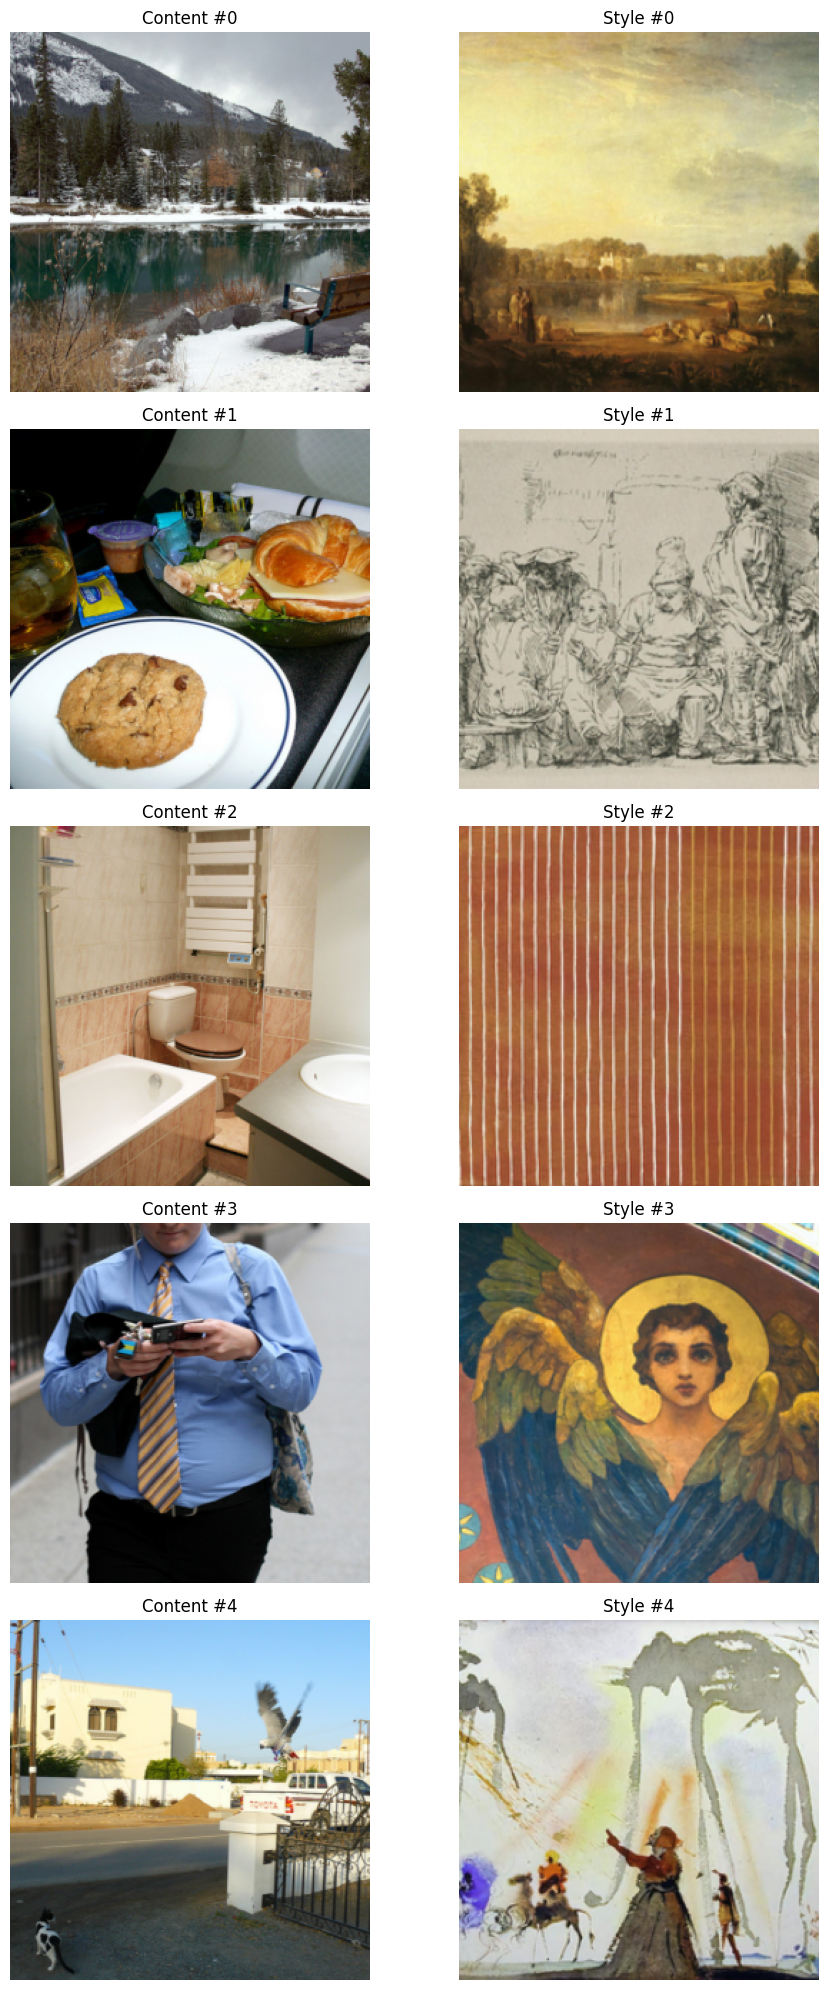

In [ ]:
import matplotlib.pyplot as plt

train_iter = make_train_iterator(content_loader, style_loader)
show_examples(train_iter, num_pairs=5)

---

# Model Testings


In [ ]:
import torch
from src.model.vgg_extractor import *

device = "cuda" if torch.cuda.is_available() else "cpu"
B = 2
x_content = torch.randn(B, 3, 252, 252, device=device)
x_style   = torch.randn(B, 3, 252, 252, device=device)

vgg_content = build_vgg_content_extractor(device)
vgg_style   = build_vgg_style_extractor(device)


with torch.no_grad():
    feats_content = vgg_content(x_content)
    feats_style   = vgg_style(x_style)


print("=== Content features ===")
for name, feat in feats_content.items():
    print(f"{name:8s} -> {tuple(feat.shape)}")

print("\n=== Style features ===")
for name, feat in feats_style.items():
    print(f"{name:8s} -> {tuple(feat.shape)}")


=== Content features ===
relu4_1  -> (2, 512, 31, 31)

=== Style features ===
relu1_1  -> (2, 64, 252, 252)
relu2_1  -> (2, 128, 126, 126)
relu3_1  -> (2, 256, 63, 63)
relu4_1  -> (2, 512, 31, 31)
relu5_1  -> (2, 512, 15, 15)


In [ ]:
from src.model.attention_fusion import *

B = 2
x_content = torch.randn(B, 3, 252, 252, device=device)
x_style   = torch.randn(B, 3, 252, 252, device=device)

fusion = StyA2KAttentionFusion(
    in_channels=512,
    key_dim=128,
    pool_hw=8,
    residual=True).to(device)


vgg_content = build_vgg_content_extractor(device)
vgg_style   = build_vgg_style_extractor(device)

with torch.no_grad():
    feats_content = vgg_content(x_content)
    feats_style = vgg_style(x_style)

    F_c = feats_content["relu4_1"]
    F_s = feats_style["relu4_1"]

    F_fused = fusion(F_c, F_s)

print("content feat:", F_c.shape)
print("style   feat:", F_s.shape)
print("fused   feat:", F_fused.shape)

content feat: torch.Size([2, 512, 31, 31])
style   feat: torch.Size([2, 512, 31, 31])
fused   feat: torch.Size([2, 512, 31, 31])


In [ ]:
from src.model.decoder_net import *

device = "cuda" if torch.cuda.is_available() else "cpu"

B = 2
x_content = torch.randn(B, 3, 252, 252, device=device)
x_style   = torch.randn(B, 3, 252, 252, device=device)

fusion = StyA2KAttentionFusion(
    in_channels=512,
    key_dim=128,
    pool_hw=8,
    residual=True).to(device)
decoder = StyA2KDecoder(out_size=(252, 252)).to(device)


vgg_content = build_vgg_content_extractor(device)
vgg_style   = build_vgg_style_extractor(device)

with torch.no_grad():
    feats_content = vgg_content(x_content)
    feats_style = vgg_style(x_style)

    F_c = feats_content["relu4_1"]
    F_s = feats_style["relu4_1"]

    F_fused = fusion(F_c, F_s)
    y = decoder(F_fused)


print("content feat:", F_c.shape)
print("style   feat:", F_s.shape)
print("fused   feat:", F_fused.shape)
print("Decoder output:", y.shape)

content feat: torch.Size([2, 512, 31, 31])
style   feat: torch.Size([2, 512, 31, 31])
fused   feat: torch.Size([2, 512, 31, 31])
Decoder output: torch.Size([2, 3, 252, 252])


In [ ]:
from src.model.styA2kNet import *

device = "cuda" if torch.cuda.is_available() else "cpu"
model = StyA2KNet(device=device).to(device)

B = 2
x_content = torch.randn(B, 3, 252, 252, device=device)
x_style   = torch.randn(B, 3, 252, 252, device=device)

with torch.no_grad():
    y = model(x_content, x_style)

print("output stylized:", y.shape)


output stylized: torch.Size([2, 3, 252, 252])


---
